# Juxtapose Two Corpus (Similarity and Polarity)

**Appropriate datasets:**
1. Tweets

**Required metadata:**
1. datetime

**Methods (Using political tweets dataset):**
1. slice the corpus into quintile 0 and quintile 4 (Left-wing, Right-wing)
2. slice the quintile 0 and quintile 4 each into monthly corpus.

**This notebook answers the following which requires more and more granular analysis:**

*1. When is there peak activity?*

Plot monthly corpus size to reveal peaks

*2. How similar are these corpus?*

Corpus similarity using cosine similarity on different metrics. (todo: this can actually be a heatmap)

*3. During the month of peak activity, what are the left saying compared to the right?*

Wordcloud that shows the more representative words and coloured based on their dominance.

In [1]:
import os
if  not 'juxtorpus' in os.listdir():
    os.chdir('../../')
assert 'juxtorpus' in os.listdir(), f"Working directory should be at juxtorpus. But at {os.getcwd()}"
f"Working directory: {os.getcwd()}"

'Working directory: /Users/hcha9747/workspace/juxtorpus'

In [2]:
from juxtorpus.viz.widgets import FileUploadWidget

# please upload in .zip format of the directories
fwidget = FileUploadWidget()
fwidget.render()

In [3]:
f"You have uploaded {len(fwidget.uploaded())} files."

'You have uploaded 1334 files.'

In [4]:
# Tristram project specific: transform text files into csv.
from scripts.tristram.quintiles_to_csv import transform
dirs = set(f.parent for f in fwidget.uploaded())
csv_paths = [transform(d) for d in dirs]

csv_paths

[INFO] Parsing files in /var/folders/jh/mqv5k4x56d98m2twhmk4bjdc0000gp/T/tmpg6pn36oh/Quintile_4 to dataframe...
[INFO] Number of files: 667
[INFO] Written to /var/folders/jh/mqv5k4x56d98m2twhmk4bjdc0000gp/T/tmpg6pn36oh/Quintile_4/Quintile_4.csv. Size: 20.980418Mb.
[INFO] Parsing files in /var/folders/jh/mqv5k4x56d98m2twhmk4bjdc0000gp/T/tmpg6pn36oh/Quintile_0 to dataframe...
[INFO] Number of files: 667
[INFO] Written to /var/folders/jh/mqv5k4x56d98m2twhmk4bjdc0000gp/T/tmpg6pn36oh/Quintile_0/Quintile_0.csv. Size: 147.328337Mb.


[PosixPath('/var/folders/jh/mqv5k4x56d98m2twhmk4bjdc0000gp/T/tmpg6pn36oh/Quintile_4/Quintile_4.csv'),
 PosixPath('/var/folders/jh/mqv5k4x56d98m2twhmk4bjdc0000gp/T/tmpg6pn36oh/Quintile_0/Quintile_0.csv')]

In [5]:
from pathlib import Path
# csv_paths = [Path('/var/folders/jh/mqv5k4x56d98m2twhmk4bjdc0000gp/T/tmp3sdug0o_/Quintile_0/Quintile_0.csv'),
#             Path('/var/folders/jh/mqv5k4x56d98m2twhmk4bjdc0000gp/T/tmp3sdug0o_/Quintile_4/Quintile_4.csv')]

import pandas as pd
pd.read_csv(csv_paths[0], nrows=1)

text  quintile        date
0  <TWEET> @TracyPa08213034 @AdamBandt That's 97%...         4  2021/12/27

In [6]:
from juxtorpus.corpus import CorpusBuilder

builder = CorpusBuilder(csv_paths)
builder.show_columns().T

All Columns   date  quintile   text
Add          False     False  False

In [7]:
builder.add_metas(['quintile'])
builder.add_metas('date', 'datetime')

import re
pattern = re.compile(r'<[/]?TWEET>')

builder.set_text_column('text')
builder.set_text_preprocessors([lambda t: pattern.sub('', t).strip()])
corpus = builder.build()
corpus.summary()

[INFO] Building document-term matrix. Please wait...
[INFO] Done.


Corpus Type                Corpus
No. Documents              831078
No. Terms                22833470
Vocabulary size            486152
No. Terms mean          27.474521
No. Terms std           14.696279
No. Terms min                 1.0
No. Terms 25%                16.0
No. Terms 50%                26.0
No. Terms 75%                40.0
No. Terms max               113.0
metas              quintile, date
dtype: object

In [8]:
# You may choose to skip this step
# corpus = corpus.slicer.sample(1000)
# corpus.summary().to_frame().T

# When is there peak activity?

In [9]:
quintiles = list(corpus.slicer.group_by('quintile'))
quintiles

[(0, <juxtorpus.corpus.corpus.Corpus at 0x177481a90>),
 (4, <juxtorpus.corpus.corpus.Corpus at 0x2c701c100>)]

In [10]:
# create a timeline using
import pandas as pd
import plotly.graph_objects as go

traces = list()
for qid, quintile in quintiles:
    time_period_groups = list(quintile.slicer.group_by('date', pd.Grouper(freq='1m')))
    trace = go.Scatter(x=[g for g, _ in time_period_groups], 
                       y=[len(c) for _, c in time_period_groups],
                      name=f"quintile {qid}")
    traces.append(trace)
# traces
fig = go.Figure(traces)
fig.update_xaxes(
    dtick="M1"
)
fig.update_layout(
    title=f"Number of tweets by month",
)
fig.show()

# How similar are these corpus?

The corpus similarity is measured using cosine similarity with a few different metrics to select from.
1. Normalised term frequency
2. TFIDF
3. Log likelihood with a baseline

In [11]:
# todo: bar, heatmap

# During the month of peak activity, what are the left saying compared to the right?

In [12]:
jan = corpus.slicer.filter_by_datetime('date', start='2020-01-01', end='2020-02-01')

[INFO] Converted start datetime : 2020y 01m 01d 00:00:00
[INFO] Converted end datetime   : 2020y 02m 01d 00:00:00


In [13]:
groups = list(jan.slicer.group_by('quintile'))
q0, q4 = groups[0][1], groups[1][1]
q0, q4

(<juxtorpus.corpus.corpus.Corpus at 0x2a41831c0>,
 <juxtorpus.corpus.corpus.Corpus at 0x2a1ace2b0>)

In [14]:
from juxtorpus import Jux

jux = Jux(q0, q4)
jux.summary().T

Corpus Type No. Documents No. Terms Vocabulary size No. Terms mean  \
corpus_0      Corpus        134284   3675719          109651      27.372725   
corpus_1      Corpus         19448    537940           30030      27.660428   

         No. Terms std No. Terms min No. Terms 25% No. Terms 50%  \
corpus_0     14.427928           1.0          16.0          26.0   
corpus_1     16.112685           1.0          14.0          25.0   

         No. Terms 75% No. Terms max           metas  
corpus_0          40.0         106.0  quintile, date  
corpus_1          41.0         106.0  quintile, date

## Word Cloud: term frequency

In [15]:
df = jux.polarity.tf()

In [16]:
from nltk.corpus import stopwords
sw = stopwords.words('english')

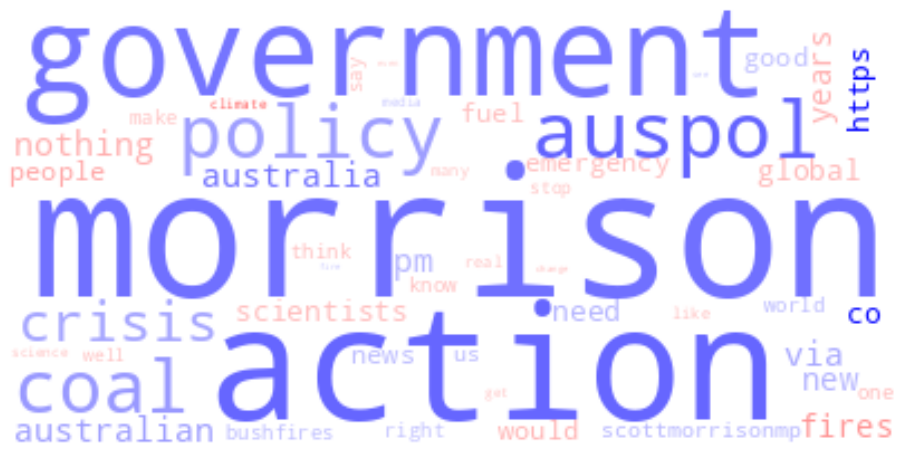

In [17]:
df = df[~df.index.isin(sw)]
df['summed'] = df['freq_corpus_0'] + df['freq_corpus_1']
df['polarity_div_summed'] = df['polarity'].abs() / df['summed']

top = 50
df_tmp = df.sort_values(by='summed', ascending=False).iloc[:top]

from juxtorpus.viz.polarity_wordcloud import PolarityWordCloud
pwc = PolarityWordCloud(df_tmp, col_polarity='polarity', col_size='polarity_div_summed')
pwc.gradate('blue', 'red').render(16, 16)

## Word Cloud: TFIDF

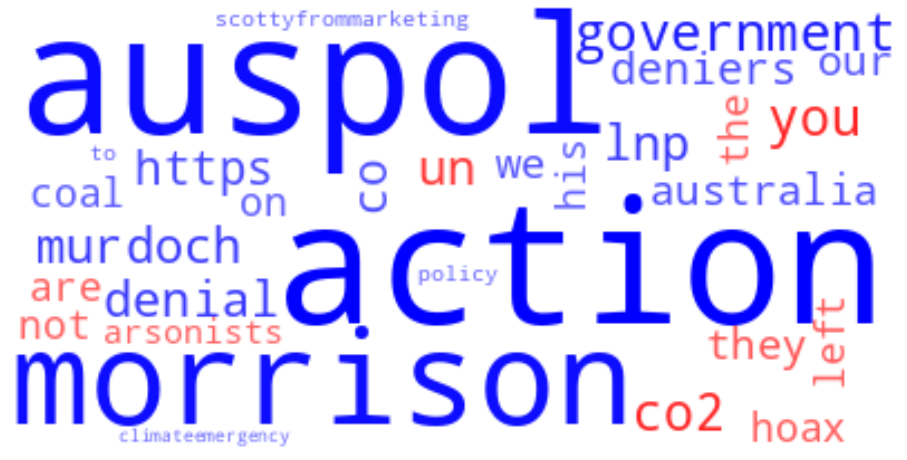

In [18]:
df = jux.polarity.tfidf()
df['size'] = df.polarity.abs()
df_tmp = df.sort_values(by='size', ascending=False).iloc[:30]
pwc = PolarityWordCloud(df_tmp, col_polarity='polarity', col_size='size')
pwc.gradate('blue', 'red').render(16, 16)

## Word Cloud: Log Likelihood

The larger the size the more 'representative' it is of both corpus.

The colour gradient describes how 'polarised' it is.

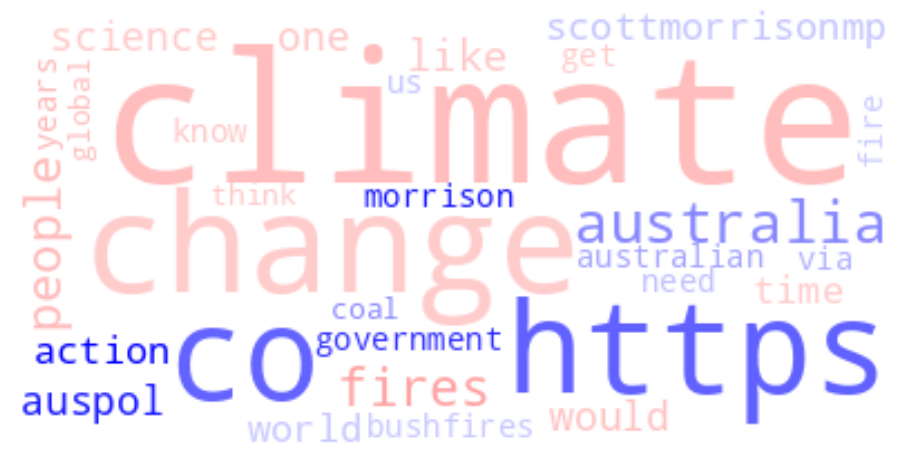

In [19]:
# Size = TF.abs()   Polarity = LLV

df = jux.polarity.log_likelihood()
tf_df = jux.polarity.tf()
df['size'] = tf_df['freq_corpus_0'] + tf_df['freq_corpus_1']
df = df[~df.index.isin(sw)]
df_tmp = df.sort_values(by='size', ascending=False).iloc[:30]
pwc = PolarityWordCloud(df_tmp, col_polarity='polarity', col_size='size')
pwc.gradate('blue', 'red').render(16, 16)

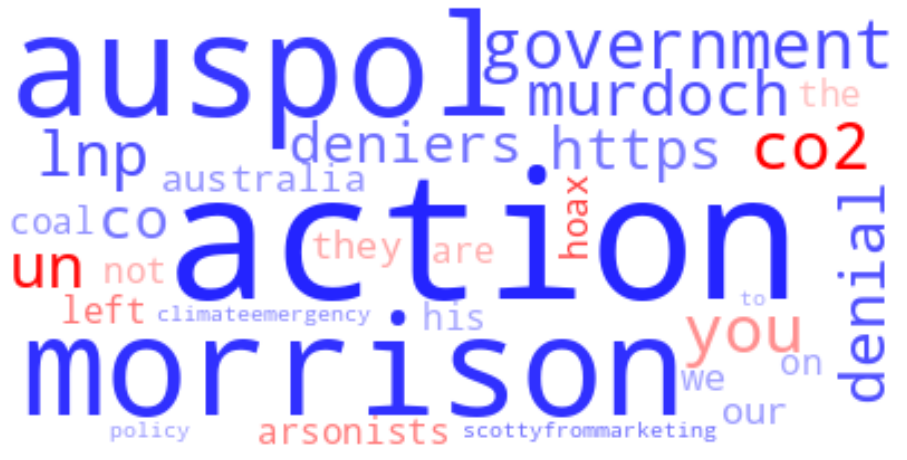

In [20]:
# Size = TFIDF.abs()   Polarity = LLV
df = jux.polarity.log_likelihood()
tfidf_df = jux.polarity.tfidf()
df['size'] = tfidf_df.polarity.abs()
df_tmp = df.sort_values(by='size', ascending=False).iloc[:30]
pwc = PolarityWordCloud(df_tmp, col_polarity='polarity', col_size='size')
pwc.gradate('blue', 'red').render(16, 16)

In [21]:
# Size = baseline extracted keywords, Polarity = LLV

import pandas as pd
from juxtorpus.corpus.freqtable import FreqTable


freqtbl_baseline = FreqTable(list(), list())
freqtbl_baseline._series = pd.read_csv('./assets/baselines/auspol_freqtable.csv', index_col=0).dropna().squeeze().rename('freq')
# issue duplicate index can't be concatenated. Hence dropped here.
freqtbl_baseline._series.drop(freqtbl_baseline._series.loc[freqtbl_baseline.series.index.duplicated()].index, inplace=True)

In [22]:
from juxtorpus.stats.loglikelihood_effectsize import log_likelihood_and_effect_size
llv_baseline = log_likelihood_and_effect_size([corpus.dtm.freq_table(), freqtbl_baseline])
llv_baseline.head(3)

freq_corpus_0  freq_corpus_1  expected_likelihoods  \
0           1778.0        19863.0              0.000122   
00           147.0         1501.0              0.000009   
000         4591.0        46421.0              0.000288   

     expected_freq_corpus_0  log_likelihood_ratio_corpus_0  \
0               2787.381205                      -0.449613   
00               212.263954                      -0.367398   
000             6570.393699                      -0.358476   

     log_likelihood_corpus_0  expected_freq_corpus_1  \
0               -1598.825186            18853.618795   
00               -108.015006             1435.736046   
000             -3291.525615            44441.606301   

     log_likelihood_ratio_corpus_1  log_likelihood_corpus_1  \
0                         0.052154              2071.863076   
00                        0.044454               133.450640   
000                       0.043576              4045.667539   

     log_likelihood_llv  bayes_factor_bic  effect_size_ell  
0            473.037890        454.044665     3.363670e-07  
00            25.435634          6.442409     2.677939e-08  
000          754.141924        735.148699     4.839440e-07

In [23]:
llvb = llv_baseline
relative = llvb['freq_corpus_0'] - llvb['freq_corpus_1']
llvb['log_likelihood_llv_signed'] = (relative*llvb.log_likelihood_llv) / relative.abs()
llvb.log_likelihood_llv_signed.head(3)

0     -473.037890
00     -25.435634
000   -754.141924
Name: log_likelihood_llv_signed, dtype: float64

In [24]:
# use the llv_baseline to find the keywords
hard_threshold = 3.4

f"Before removal: {len(llvb)}, After: {len(llvb[llvb.log_likelihood_llv_signed > hard_threshold])}"

'Before removal: 1638929, After: 16929'

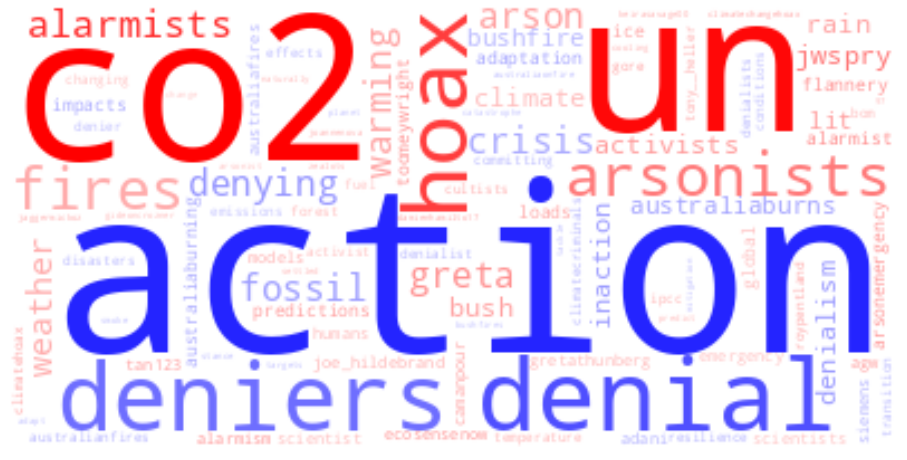

In [25]:
df = jux.polarity.log_likelihood()
# preprocessing - remove non keywords
df['llvb_signed'] = llvb.log_likelihood_llv_signed
df = df[df['llvb_signed'] > hard_threshold]

tfidf_df = jux.polarity.tfidf()
df['size'] = tfidf_df.polarity.abs()
df_tmp = df.sort_values(by='size', ascending=False).iloc[:100]
pwc = PolarityWordCloud(df_tmp, col_polarity='polarity', col_size='size')
pwc.gradate('blue', 'red').render(16, 16)

## Wordcloud: # only

In [26]:
import spacy
from juxtorpus.corpus.processors import process

nlp = spacy.blank('en')

s_corpus = process(corpus, nlp=nlp)
s_corpus.summary()

[INFO] Processing corpus of 831078 documents...
[INFO] Done.
[INFO] Building document-term matrix. Please wait...
[INFO] Done.


Corpus Type           SpacyCorpus
No. Documents              831078
No. Terms                19834101
Vocabulary size            114212
No. Terms mean          23.865511
No. Terms std            13.51187
No. Terms min                 0.0
No. Terms 25%                12.0
No. Terms 50%                22.0
No. Terms 75%                36.0
No. Terms max                62.0
metas              quintile, date
dtype: object

In [27]:
s = s_corpus.slicer.filter_by_datetime('date', start='2020-01-01', end='2020-02-01')

[INFO] Converted start datetime : 2020y 01m 01d 00:00:00
[INFO] Converted end datetime   : 2020y 02m 01d 00:00:00


In [28]:
list(s.slicer.group_by('quintile'))

[(0, <juxtorpus.corpus.corpus.SpacyCorpus at 0x2c4eeb8e0>),
 (4, <juxtorpus.corpus.corpus.SpacyCorpus at 0x2c4eebdf0>)]

In [29]:
list(s_corpus.slicer.group_by('quintile'))

[(0, <juxtorpus.corpus.corpus.SpacyCorpus at 0x2c4ef97f0>),
 (4, <juxtorpus.corpus.corpus.SpacyCorpus at 0x2c4ef96a0>)]

In [30]:
# this is a new corpus after being processed by spacy, so we need to slice and create jux again.
groups = list(s_corpus.slicer.filter_by_datetime('date', start='2020-01-01', end='2020-02-01').slicer.group_by('quintile'))
q0, q4 = groups[0][1], groups[1][1]
jux = Jux(q0, q4)

[INFO] Converted start datetime : 2020y 01m 01d 00:00:00
[INFO] Converted end datetime   : 2020y 02m 01d 00:00:00


[INFO] Building document-term matrix. Please wait...
[INFO] Done.
[INFO] Building document-term matrix. Please wait...
[INFO] Done.


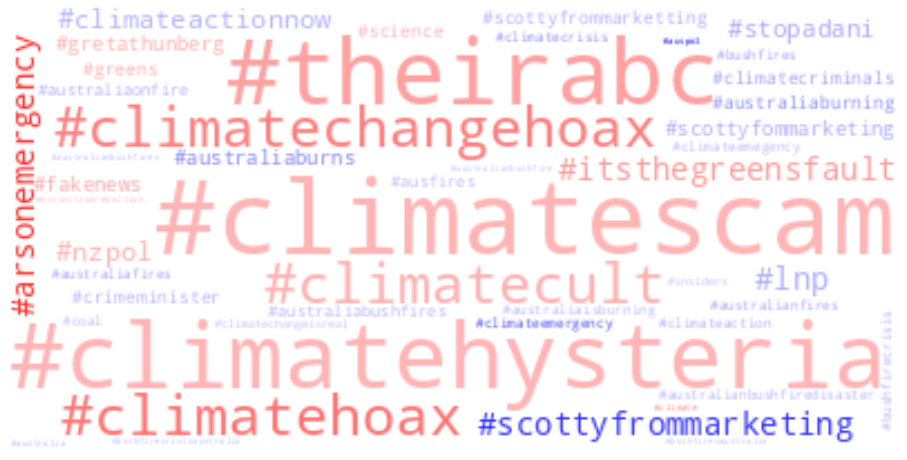

In [32]:
from juxtorpus.matchers import hashtags

matcher = hashtags(nlp.vocab)
def gen_hashtags_from(doc):
    return (doc[s:e].text.lower() for _, s, e in matcher(doc))
    

df = jux.polarity.tf(tokeniser_func=gen_hashtags_from)

df['summed'] = df['freq_corpus_0'] + df['freq_corpus_1']
df['polarity_div_summed'] = df['polarity'].abs() / df['summed']

top = 50
df_tmp = df.sort_values(by='summed', ascending=False).iloc[:top]

pwc = PolarityWordCloud(df_tmp, col_polarity='polarity', col_size='polarity_div_summed')
pwc.gradate('blue', 'red').render(16, 16)